In [39]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("../zippedData/tn.movie_budgets.csv.gz")
len(df)

df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [40]:
#removes commas, dollar signs and converts all numerical data to float
def string_to_float(string):
    return float(string.replace('$', '').replace(',',''))
df['worldwide_gross'] = df['worldwide_gross'].apply(lambda x: string_to_float(x))
df['production_budget'] = df['production_budget'].apply(lambda x: string_to_float(x))
df['domestic_gross'] = df['domestic_gross'].apply(lambda x: string_to_float(x))

#drops the first porno movie shown in theaters which made 175,500 times its budget
#Its both a massive outlier and presumably no longer possible in the industry microsoft is trying to break in to

df = df[df.movie != 'Deep Throat']

#getting rid of movies that have a 0 for worldwide gross AND domestic gross 
#some movies certainly make 0 dollars, but in this df its used as a placeholder
#an | is neccesary as a movie may only have made money worldwide or domestically

df = df[(df.worldwide_gross>0)|(df.domestic_gross>0)]

df['year'] = df['release_date'].apply(lambda x: int(x[-4:]))
df = df[df.year>1980]
len(df)

5135

In [41]:
#creating various profit and roi columns, by subtracting budget from gross and dividing by budget

df['profit'] = df['worldwide_gross'] - df['production_budget'] 
df['domestic_profit'] = df['domestic_gross'] - df['production_budget']
df['has foriegn'] = df['worldwide_gross'] > 0
df['roi'] = (df['profit']/ df['production_budget'])*100
df['domestic_roi'] = (df['domestic_profit']/ df['production_budget']) * 100

#these function find outliers from the data and are designed to be applicable to any df 

def get_iqr(df, col_name):
    hq = df[col_name].quantile(0.75) 
    median = df[col_name].quantile(0.5)
    lq = df[col_name].quantile(0.15)
    iqr = hq-lq
    return iqr, median

def is_outlier(x, iqr, median):
    if x > median + iqr*1.5:
        return True
    elif x < median - 1.5*iqr:
        return True
    else:
        return False

def find_outliers(df, column):
    """
    Returns a boolean series. True if outside IQR*1.5 range, False otherwise
    """
    IQR , median  = get_iqr(df, column)
    return df[column].apply(lambda x: is_outlier(x, IQR, median))

df['outlier_budget'] = find_outliers(df, 'production_budget' )

    
#categorized each movie by the size of its budget as either 'large', 'medium' or 'small', our groupings
#are based on industry standards NOTE: these values are mostly arbitrary as different people may consider a
#$5 million not a small budget, theres no official definition. 


def categorize_production(x):
    m = int(x)
    k=''
    if m < 5000000:
        k = 'small'
    if 5000000 <= m <= 100000000:
        k = 'medium'
    if m > 100000000:
        k = 'large'
    return k

df['budget_category'] = df['production_budget'].apply(lambda x: categorize_production(x))

Text(0.5, 1.0, 'Distribution of Production Budget Data ')

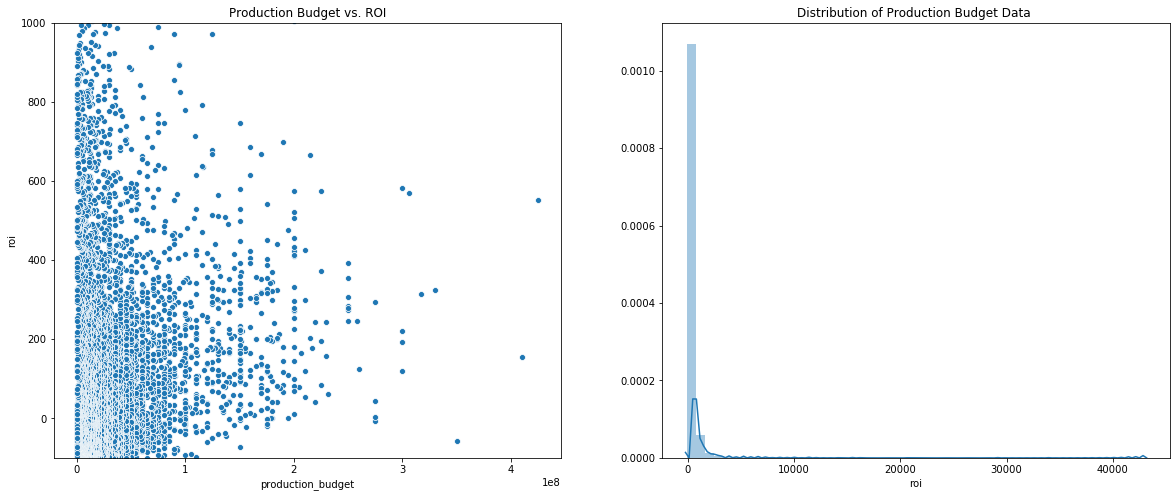

In [42]:
# fetching roi data for each category to use in future graphs

s_x = df[(df.budget_category == 'small')&(df.outlier_budget == False)]['roi']

m_x = df[(df.budget_category == 'medium')&(df.outlier_budget == False)]['roi']

l_x = df[(df.budget_category == 'large')&(df.outlier_budget == False)]['roi']

#creating a new column that returns True if a film lost money

df['lost_money'] = [x < 0 for x in df['roi']]

#plotting production budget vs roi and a distribution of roi
fig2, axes = plt.subplots(1,2, figsize = (20,8))
ax = sns.scatterplot(df['production_budget'], df['roi'], ax= axes[0])
ax1 = sns.distplot(df['roi'], ax= axes[1])
ax.set(ylim = (-100,1000))
ax.set_title('Production Budget vs. ROI')
ax1.set_title('Distribution of Production Budget Data ')

Text(0.5, 1.0, 'Distribution of Production Budget Data for Large Budget Movies')

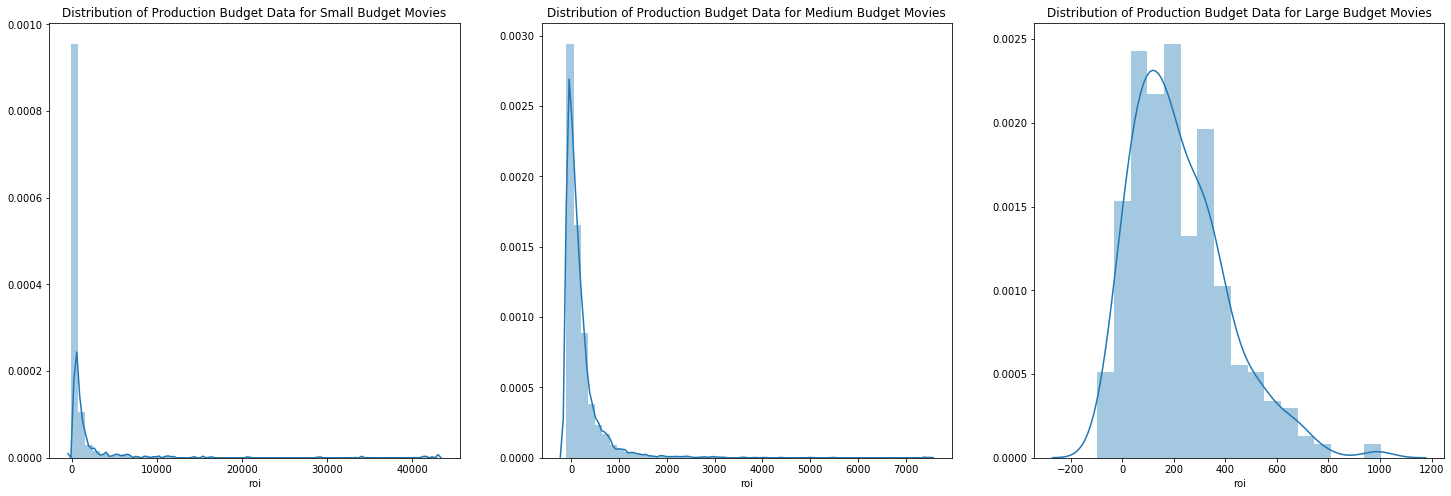

In [43]:
f, axes = plt.subplots(1,3, figsize=(25, 8), sharex=False)

ax2 = sns.distplot(df[df.budget_category == 'small']['roi'], ax = axes[0])
ax2.set_title('Distribution of Production Budget Data for Small Budget Movies')
ax3 = sns.distplot(df[df.budget_category == 'medium']['roi'], ax = axes[1])
ax3.set_title('Distribution of Production Budget Data for Medium Budget Movies')
ax4 = sns.distplot(df[df.budget_category == 'large']['roi'], ax = axes[2]);
ax4.set_title('Distribution of Production Budget Data for Large Budget Movies')


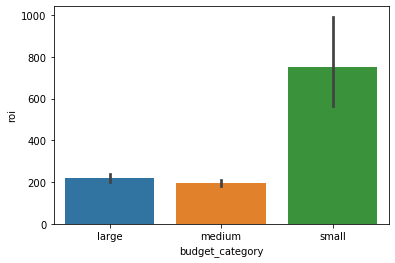

In [44]:

sns.barplot(y= df['roi'], x = df['budget_category'])

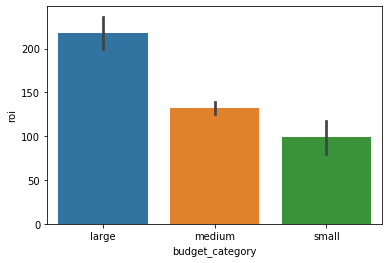

In [45]:
#y = df[df.outlier_budget == True]['roi']
y =df[df.roi<1000]['roi']
sns.barplot(y= y, x = df['budget_category'])

In [46]:
len(df[df['lost_money']==True])

1723

In [47]:
#Calculating the percent that lost money from each category
p_lost_money_small = len(df[(df.budget_category == 'small') & (df.lost_money == True)])/len(df[df.budget_category =='small'])

p_lost_money_medium = len(df[(df.budget_category == 'medium') & (df.lost_money == True)])/len(df[df.budget_category =='medium'])

p_lost_money_large = len(df[(df.budget_category == 'large') & (df.lost_money == True)])/len(df[df.budget_category =='large'])

#and the average amount of money lost
avg_lost_money_l = abs(sum(df[(df.budget_category == 'large') & (df.lost_money == True)]['profit'])/len(df[df.budget_category == 'large']))
                           
avg_lost_money_m = abs(sum(df[(df.budget_category == 'medium') & (df.lost_money == True)]['profit'])/len(df[df.budget_category == 'medium']))
                           
avg_lost_money_s = abs(sum(df[(df.budget_category == 'small') & (df.lost_money == True)]['profit'])/len(df[df.budget_category == 'small']))
                           

x = ['Small Budget', 'Medium Budget', 'Large Budget']
y = [p_lost_money_small, p_lost_money_medium, p_lost_money_large]
y2 = [avg_lost_money_l, avg_lost_money_s, avg_lost_money_m]

Text(0.5, 1.0, 'Percentage of movies that lost money in each budget category')

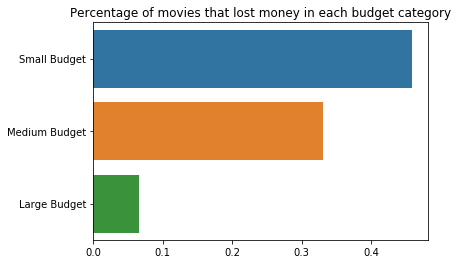

In [48]:
#Plotting
ax = sns.barplot(y, x);
ax.set_title('Percentage of movies that lost money in each budget category')

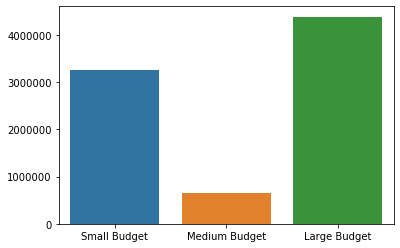

In [49]:
ax = sns.barplot(x, y2);
